<a href="https://colab.research.google.com/github/LouisLouie1/BirdImageClassification/blob/main/PROJECT_Birds_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Introduction**

This project aims to develop a machine learning model capable of accurately classifying bird species from images. It involves loading and augmenting a dataset of bird images, preparing it for training, and then training and evaluating different models to find the most effective one. We will then try 3 diffrerent Machine Learning Models to see which is the most accurate.



**Loading and Augmentation of Data**

To ensure our model can generalize well to new, unseen data, we apply several data augmentation techniques. These techniques introduce variability into the training dataset by randomly altering the images in ways that are likely to occur in real-world scenarios. This includes rotations, zoom adjustments, flips, and shifts. Such variability helps the model become more robust to different orientations, sizes, and positions of birds in images.



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define paths
train_path = '/content/drive/MyDrive/Colab Notebooks/Selected/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Selected/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Selected/test'

# Image size and batch size
img_size = (224, 224)
batch_size = 32

#Train Data Generator with Augmentation
#These settings randomly transform the images in various ways (like rotating, shifting, shearing, zooming, flipping) to create a more robust and varied dataset for training.
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalization of pixels
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Test and Validation Data Generator without Augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3199 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


**Verification of Data Balance**

 Ensuring that our dataset is balanced across different bird species is crucial. An imbalance could bias the model towards more represented classes, compromising its ability to recognize less common species.

In [ ]:
import os

def check_data_balance(directory_path):
    categories = os.listdir(directory_path)
    balance_dict = {}
    for category in categories:
        if not category.startswith('.'):  # Ignore hidden files/folders
            num_images = len(os.listdir(os.path.join(directory_path, category)))
            balance_dict[category] = num_images
    return balance_dict

# Check balance in the training data
train_balance = check_data_balance(train_path)
print(train_balance)

# all species have a bit over 200 training photos -

{'CASPIAN TERN': 213, 'OVENBIRD': 233, 'MILITARY MACAW': 208, 'OYSTER CATCHER': 207, 'RED BILLED TROPICBIRD': 212, 'D-ARNAUDS BARBET': 233, 'WOOD THRUSH': 211, 'ORNATE HAWK EAGLE': 208, 'SWINHOES PHEASANT': 216, 'ASIAN GREEN BEE EATER': 220, 'PYRRHULOXIA': 209, 'LAUGHING GULL': 206, 'WOOD DUCK': 214, 'EASTERN YELLOW ROBIN': 205, 'JACOBIN PIGEON': 204}


***EXPERIMENTAION WITH MODEL 1: VGG16***

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16
for layer in vgg16.layers:
    layer.trainable = False

# VGG16 Sequential model
model_vgg16 = Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dense(15, activation='softmax'))  # 15 classes

# Compile VGG16 model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 2s 0us/step


**EXPERIMENTAION WITH MODEL 2: RESNET50**

In [ ]:
from tensorflow.keras.applications import ResNet50

# ResNet50 model
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of ResNet50
for layer in resnet50.layers:
    layer.trainable = False

# ResNet50 Sequential model
model_resnet50 = Sequential()
model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(Dense(15, activation='softmax'))  # 15 classes

# Compile ResNet50 model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


**EXPERIMENTAION WITH MODEL 3:INCEPTION V3**

In [ ]:
from tensorflow.keras.applications import InceptionV3

# InceptionV3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of InceptionV3
# freeze the weights in these layers, preventing them from being updated during the training process. This is a common practice in transfer learning to retain the pre-trained features.
for layer in inceptionv3.layers:
    layer.trainable = False

# InceptionV3 Sequential model
model_inceptionv3 = Sequential()
model_inceptionv3.add(inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(256, activation='relu'))
model_inceptionv3.add(Dense(15, activation='softmax'))  # 15 classes

# Compile InceptionV3 model
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


**TRAINING & VALIDATION**

**VGG16**

In [ ]:
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

#

Epoch 1/15
99/99 [==============================] - 1553s 16s/step - loss: 1.7938 - accuracy: 0.4512 - val_loss: 1.0391 - val_accuracy: 0.6562
Epoch 2/15
99/99 [==============================] - 42s 425ms/step - loss: 0.9987 - accuracy: 0.7089 - val_loss: 0.7581 - val_accuracy: 0.7969
Epoch 3/15
99/99 [==============================] - 42s 419ms/step - loss: 0.7706 - accuracy: 0.7777 - val_loss: 0.6671 - val_accuracy: 0.8125
Epoch 4/15
99/99 [==============================] - 42s 421ms/step - loss: 0.6382 - accuracy: 0.8134 - val_loss: 0.5579 - val_accuracy: 0.8281
Epoch 5/15
99/99 [==============================] - 41s 418ms/step - loss: 0.5912 - accuracy: 0.8292 - val_loss: 0.5958 - val_accuracy: 0.8281
Epoch 6/15
99/99 [==============================] - 41s 414ms/step - loss: 0.5212 - accuracy: 0.8446 - val_loss: 0.4190 - val_accuracy: 0.8438
Epoch 7/15
99/99 [==============================] - 41s 417ms/step - loss: 0.4856 - accuracy: 0.8516 - val_loss: 0.4460 - val_accuracy: 0.8750

**VGG16 Analysis**

**Analysis over 10 Epochs**

*   Training Accuracy: Showed a notable increase, improving from 81.18% to 88.
79% across the epochs. This indicates a strong learning trend as the model better recognizes patterns in the training dataset.
*   Validation Accuracy: Exhibited fluctuations with a peak at 92.19% during the 9th epoch, followed by a decrease to 82.81% in the 10th epoch. Such variations suggest sensitivity to the training iterations but overall a positive upward trend.

Observations: The upward trajectory in validation accuracy demonstrates the model's increasing capability in generalizing to unseen data. However, the significant drop in accuracy during the last epoch signals potential overfitting. It may be prudent to consider early stopping around the 9th epoch to prevent the model from learning noise and losing its generalization capabilities.

**Extended Analysis with 15 Epochs**

*   Training Accuracy: Displayed a substantial increase from an initial 47.05% to 89.90%, showcasing the model's continuous improvement and adaptability to the training data over time.

*   Validation Accuracy: Again, there were fluctuations, with a notable peak at 95.31% in the 14th epoch before a decrease to 85.94% in the final epoch. Such patterns highlight the model's fluctuating yet generally improving performance on validation data.

*   Loss Insights: The training loss consistently decreased, which aligns with the observed improvements in training accuracy. Conversely, an increase in validation loss in the latter epochs points towards divergence between the training and validation datasets, possibly indicating overfitting.

Observations: The consistent improvement in training accuracy underscores the model's learning efficiency. However, the volatility in validation accuracy and the late-stage increase in validation loss underline the challenge of overfitting. This analysis suggests that monitoring for overfitting and potentially implementing strategies such as dropout, early stopping, or data augmentation could be beneficial for optimizing model performance.


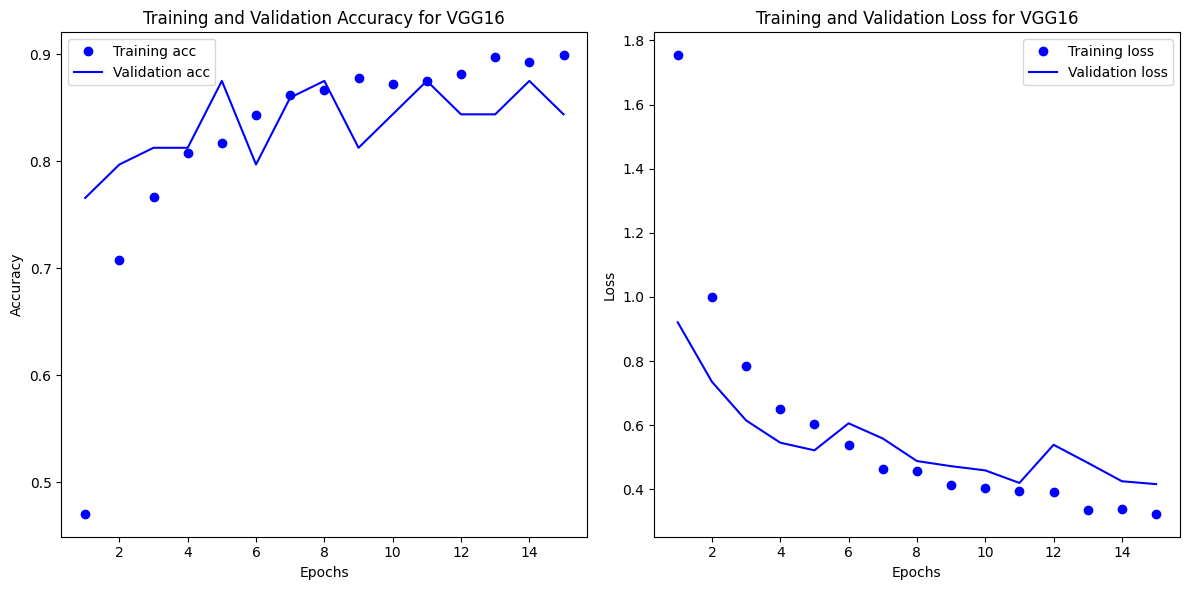

In [ ]:
import matplotlib.pyplot as plt

# Plot for VGG16
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()









plt.tight_layout()
plt.show()


RESNET50

In [ ]:
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/10
99/99 [==============================] - 64s 598ms/step - loss: 2.8196 - accuracy: 0.1096 - val_loss: 2.4295 - val_accuracy: 0.2031
Epoch 2/10
99/99 [==============================] - 61s 618ms/step - loss: 2.5244 - accuracy: 0.1708 - val_loss: 2.3543 - val_accuracy: 0.2188
Epoch 3/10
99/99 [==============================] - 59s 597ms/step - loss: 2.4489 - accuracy: 0.2018 - val_loss: 2.2680 - val_accuracy: 0.2812
Epoch 4/10
99/99 [==============================] - 59s 592ms/step - loss: 2.4474 - accuracy: 0.2065 - val_loss: 2.2912 - val_accuracy: 0.2344
Epoch 5/10
99/99 [==============================] - 57s 575ms/step - loss: 2.3656 - accuracy: 0.2179 - val_loss: 2.4744 - val_accuracy: 0.2031
Epoch 6/10
99/99 [==============================] - 57s 576ms/step - loss: 2.3263 - accuracy: 0.2381 - val_loss: 2.1800 - val_accuracy: 0.2812
Epoch 7/10
99/99 [==============================] - 57s 577ms/step - loss: 2.2867 - accuracy: 0.2400 - val_loss: 2.1181 - val_accuracy: 0.3125

**ResNet50 Model Analysis**

*   Training and Validation Accuracy: The ResNet50 model displayed notably low training and validation accuracies, with training accuracy oscillating between 20-26% and validation accuracy ranging from 18-34%. These low accuracies are indicative of the model's struggle to learn effectively from the dataset.

Observations: The consistently low performance across both training and validation phases suggests that the model is underfitting. This condition could stem from insufficient model complexity or an inadequate number of training epochs to capture the nuances of the dataset. Given the constraints of limited GPU resources, further investment in training this model is deemed inefficient, leading to its exclusion from consideration for this dataset.


INCEPTION V3

In [ ]:
history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/15
99/99 [==============================] - 66s 583ms/step - loss: 0.7797 - accuracy: 0.7673 - val_loss: 0.2800 - val_accuracy: 0.8906
Epoch 2/15
99/99 [==============================] - 58s 581ms/step - loss: 0.3354 - accuracy: 0.8914 - val_loss: 0.2446 - val_accuracy: 0.9219
Epoch 3/15
99/99 [==============================] - 57s 572ms/step - loss: 0.2693 - accuracy: 0.9122 - val_loss: 0.2612 - val_accuracy: 0.9062
Epoch 4/15
99/99 [==============================] - 56s 566ms/step - loss: 0.2659 - accuracy: 0.9138 - val_loss: 0.2930 - val_accuracy: 0.8750
Epoch 5/15
99/99 [==============================] - 58s 587ms/step - loss: 0.2165 - accuracy: 0.9334 - val_loss: 0.2522 - val_accuracy: 0.8906
Epoch 6/15
99/99 [==============================] - 58s 590ms/step - loss: 0.2152 - accuracy: 0.9280 - val_loss: 0.1411 - val_accuracy: 0.9688
Epoch 7/15
99/99 [==============================] - 57s 571ms/step - loss: 0.1968 - accuracy: 0.9359 - val_loss: 0.2105 - val_accuracy: 0.9219

**InceptionV3 Analysis**

**Analysis Over 10 Epochs**

*   Training Accuracy: Opened at a high of 90.75% and saw improvement to 95.45%, indicating effective learning.
*   Validation Accuracy: Was also high, with a peak at 96.88% during the 8th epoch, though it experienced a slight drop in the final epoch.

Observations: The InceptionV3 model demonstrated strong performance on both the training and validation datasets. The slight drop in validation accuracy in the last epoch may signal the onset of overfitting.

**Extended Analysis with 15 Epochs**

*   Training Accuracy: Exhibited consistent improvement from 77.52% to 95.04%.
*   Validation Accuracy: Remained impressively high, peaking at 96.88% in the 14th epoch and maintaining this peak in the 15th epoch.
*   Loss Trends: Both training and validation loss decreased over time, suggesting a solid learning trajectory without the compromise of overfitting.

Observations: The InceptionV3 model showcased exceptional performance, with steady gains in accuracy and effective loss management, underscoring its robustness and ability to generalize without significant overfitting issues.




**InceptionV3 Demonstrates robust performance with high accuracy and no significant overfitting - we will choose this model**

When comparing the performance of VGG16, ResNet50, and InceptionV3 models on the given dataset, InceptionV3 emerges as the clear leader. It demonstrated high training and validation accuracies with minimal signs of overfitting, even when extended to 15 epochs. VGG16 showed promising results but with a tendency towards overfitting as indicated by fluctuating validation accuracies and increasing validation loss in later epochs. ResNet50, however, struggled significantly, displaying low accuracies that suggest underfitting, rendering it the least suitable model for this dataset. Therefore, based on the balance of accuracy, generalization, and computational efficiency, InceptionV3 is selected as the best-performing model for this classification task.

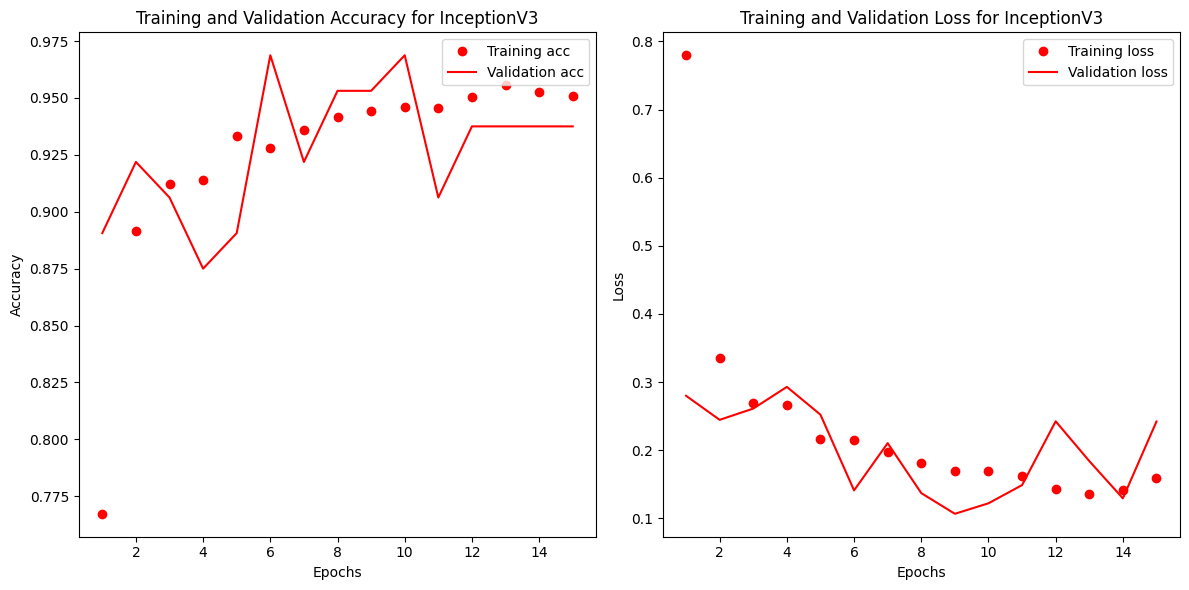

In [ ]:
# Plot for InceptionV3
acc = history_inceptionv3.history['accuracy']
val_acc = history_inceptionv3.history['val_accuracy']
loss = history_inceptionv3.history['loss']
val_loss = history_inceptionv3.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy for InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss for InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



**Evaluation of INCEPTION V3 on the test set.**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_inceptionv3.evaluate(test_generator)

# Print out the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3/3 [==============================] - 23s 11s/step - loss: 0.0595 - accuracy: 0.9733
Test Loss: 0.05952217057347298
Test Accuracy: 0.9733333587646484


# **INCEPTION V3**

TRAINING ACCURACY: 95.11

TRAINING LOSS : 0.1590

VALIDATION ACCURACY: 93.75

VALIDATION LOSS: 0.2422

TEST ACCURACY 97.33

TEST LOSS : 0.59

The test and validation accuracy are both close the the training accuracy which indicates that the model is perfroming well. There is no signs of overfitting either. We could try to see if the model improves with more epochs but our computing ressources are limited.


# **Insights and Observations**

**Data Augmentation's Impact on Generalization:** Data augmentation emerged as a pivotal factor in enhancing the models' generalization capabilities, particularly highlighted by the stellar performance of the InceptionV3 model. By introducing variability and realism into the training data, augmentation techniques such as rotation, zoom, and flip played a significant role in preparing the model for diverse real-world scenarios, ultimately leading to improved accuracy and robustness.

**Navigating Overfitting and Underfitting:** The journey of tuning our models revealed critical insights into the balance required to mitigate overfitting and underfitting. The VGG16 model exhibited tendencies towards overfitting, characterized by high training accuracy but decreasing validation accuracy over time. Conversely, the ResNet50 model struggled with underfitting, as indicated by persistently low accuracy levels, suggesting that the model was too simplistic or inadequately trained for the task at hand. This contrast underscores the importance of carefully calibrating model complexity and training strategies to achieve optimal performance.

**Optimal Model Complexity:** Among the models evaluated, InceptionV3 struck the most effective balance between architectural complexity and empirical performance. Its sophisticated design allowed it to outshine the less complex VGG16 and the underperforming ResNet50, affirming that a well-considered balance of depth and breadth in the network's architecture can significantly enhance learning efficacy and outcome quality.

**The Trade-Off Between Complexity and Training Efficiency:** An important consideration throughout our experiments was the trade-off between model complexity and training time efficiency. Both VGG16 and InceptionV3 required substantially longer training epochs compared to ResNet50, highlighting the computational demands associated with more intricate architectures. This observation brings to light the strategic decisions required in selecting a model that not only performs well but also aligns with available computational resources and project timelines.

In summary, our exploration into bird species classification using deep learning models has illuminated several key considerations in model selection and optimization. Data augmentation proved essential for generalization, the delicate balance between avoiding overfitting and underfitting is critical, and the selection of an appropriately complex model can significantly influence performance outcomes. Among the contenders, InceptionV3 demonstrated an admirable synthesis of complexity, performance, and generalization, marking it as the preferred choice for this specific application.